# Aula 8 - Random Search

Na aula de hoje, vamos explorar os seguintes tópicos em Python

- 1) breve revisão sobre o GridSearch para seleção de hiperparâmetros
- 2) RandomSearch como uma ferramenta alternativa ao GridSearch

## Exercícios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix



# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 70
pd.options.display.max_columns = 30
from sklearn.model_selection import train_test_split

### Aula 6 - Exercício 3

In [2]:
houses = pd.read_csv("house_prices.csv")

In [4]:
low_corr_cols = houses.corr()['SalePrice'].abs() <= 0.20

In [5]:
houses_filtered = houses.select_dtypes(include='number')
houses_filtered = houses_filtered.drop(columns=houses_filtered.columns[low_corr_cols])
houses_filtered = houses_filtered.dropna()

In [7]:
X = houses_filtered.drop(columns=['SalePrice'], axis=1)
y = houses_filtered["SalePrice"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [10]:
## Previnindo overfitting

lista_etapas = [("std_scaler", StandardScaler()), 
                ("dtr", DecisionTreeRegressor())]

pipe = Pipeline(lista_etapas)

# ====================

# aqui, kfold normal pq nao tem classe pra estratificar
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "r2"

# ====================

param_grid = {"dtr__criterion" : ['squared_error', 'friedman_mse', 'absolute_error'],
              "dtr__splitter" : ['best', 'random'],
              "dtr__max_depth" : range(3, 15),
              "dtr__min_samples_leaf" : range(1, 5)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_dtc_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=metrica,
                            cv=splitter,
                            verbose=10,
                            n_jobs=-1)

grid_dtc_reg.fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('dtr', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'dtr__criterion': ['squared_error', 'friedman_mse',
                                            'absolute_error'],
                         'dtr__max_depth': range(3, 15),
                         'dtr__min_samples_leaf': range(1, 5),
                         'dtr__splitter': ['best', 'random']},
             scoring='r2', verbose=10)

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# predições de treino
y_pred_train = grid_dtc_reg.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")

# predições de teste
y_pred_test = grid_dtc_reg.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")


Métricas de treino:

R^2: 0.91

Métricas de teste:

R^2: 0.74


In [12]:
grid_dtc_reg.best_params_

{'dtr__criterion': 'absolute_error',
 'dtr__max_depth': 6,
 'dtr__min_samples_leaf': 2,
 'dtr__splitter': 'best'}

### Aula 7 - Exercício 3

In [16]:
df = pd.read_csv("../datasets/insurance.csv")

In [17]:
df['flag_sex'] = np.where(df['sex'] == 'female', 1, 0)

In [18]:
df['is_smoker'] = np.where(df['smoker'] == 'yes', 1, 0)

In [19]:
df['target'] = np.where(df['charges'] < 10000, 0, np.where(df['charges'] < 30000, 1, 2))

In [20]:
df = df.drop(columns=['sex', 'smoker', 'region', 'charges'])

In [16]:
df

,age,bmi,children,flag_sex,is_smoker,target
0,19,27.900,0,1,1,1
1,18,33.770,1,0,0,0
2,28,33.000,3,0,0,0
3,33,22.705,0,0,0,1
4,32,28.880,0,0,0,0
...,...,...,...,...,...,...
1333,50,30.970,3,0,0,1
1334,18,31.920,0,1,0,0
1335,18,36.850,0,1,0,0
1336,21,25.800,0,1,0,0


In [21]:
X = df.drop('target', axis=1)
y = df['target']

In [22]:
y.value_counts(normalize=True)

0    0.532138
1    0.346786
2    0.121076
Name: target, dtype: float64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [24]:
lista_etapas = [("dt", DecisionTreeClassifier())]

pipe_dt = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## ====================

metrica = make_scorer(f1_score, pos_label="f1")

## ====================

param_grid = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(4, 11)}

grid_dt = GridSearchCV(estimator=pipe_dt, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_dt.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV 1/10; 1/28] START dt__criterion=gini, dt__max_depth=4, dt__splitter=best....
[CV 1/10; 1/28] END dt__criterion=gini, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 2/10; 1/28] START dt__criterion=gini, dt__max_depth=4, dt__splitter=best....
[CV 2/10; 1/28] END dt__criterion=gini, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 3/10; 1/28] START dt__criterion=gini, dt__max_depth=4, dt__splitter=best....
[CV 3/10; 1/28] END dt__criterion=gini, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 4/10; 1/28] START dt__criterion=gini, dt__max_depth=4, dt__splitter=best....
[CV 4/10; 1/28] END dt__criterion=gini, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 5/10; 1/28] START dt__criterion=gini, dt__max_depth=4, dt__splitter=best....
[CV 5/10; 1/28] END dt__criterion=gini, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[C

[CV 4/10; 8/28] END dt__criterion=gini, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 5/10; 8/28] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 5/10; 8/28] END dt__criterion=gini, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 6/10; 8/28] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 6/10; 8/28] END dt__criterion=gini, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 7/10; 8/28] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 7/10; 8/28] END dt__criterion=gini, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 8/10; 8/28] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 8/10; 8/28] END dt__criterion=gini, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 9/10; 8/28] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 9/10; 8/28] END dt__criterion=gini, dt__max_depth=7

[CV 2/10; 15/28] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 3/10; 15/28] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=best
[CV 3/10; 15/28] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 4/10; 15/28] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=best
[CV 4/10; 15/28] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 5/10; 15/28] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=best
[CV 5/10; 15/28] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 6/10; 15/28] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=best
[CV 6/10; 15/28] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=nan total time=   0.0s
[CV 7/10; 15/28] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=best
[CV 7/10; 15/28] END dt__criterion=entropy, d

[CV 2/10; 22/28] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 2/10; 22/28] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 3/10; 22/28] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 3/10; 22/28] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 4/10; 22/28] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 4/10; 22/28] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 5/10; 22/28] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 5/10; 22/28] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 6/10; 22/28] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 6/10; 22/28] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=nan total time=   0.0s
[CV 7/10; 22/28] START dt

[CV 6/10; 27/28] END dt__criterion=entropy, dt__max_depth=10, dt__splitter=best;, score=nan total time=   0.0s
[CV 7/10; 27/28] START dt__criterion=entropy, dt__max_depth=10, dt__splitter=best
[CV 7/10; 27/28] END dt__criterion=entropy, dt__max_depth=10, dt__splitter=best;, score=nan total time=   0.0s
[CV 8/10; 27/28] START dt__criterion=entropy, dt__max_depth=10, dt__splitter=best
[CV 8/10; 27/28] END dt__criterion=entropy, dt__max_depth=10, dt__splitter=best;, score=nan total time=   0.0s
[CV 9/10; 27/28] START dt__criterion=entropy, dt__max_depth=10, dt__splitter=best
[CV 9/10; 27/28] END dt__criterion=entropy, dt__max_depth=10, dt__splitter=best;, score=nan total time=   0.0s
[CV 10/10; 27/28] START dt__criterion=entropy, dt__max_depth=10, dt__splitter=best
[CV 10/10; 27/28] END dt__criterion=entropy, dt__max_depth=10, dt__splitter=best;, score=nan total time=   0.0s
[CV 1/10; 28/28] START dt__criterion=entropy, dt__max_depth=10, dt__splitter=random
[CV 1/10; 28/28] END dt__criter

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('dt', DecisionTreeClassifier())]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(4, 11),
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(f1_score, pos_label=f1), verbose=10)

In [25]:
grid_dt.best_estimator_

Pipeline(steps=[('dt', DecisionTreeClassifier(max_depth=4))])


Métricas de avaliação de treino:
[[559  10   0]
 [ 54 317   0]
 [  1  12 117]]


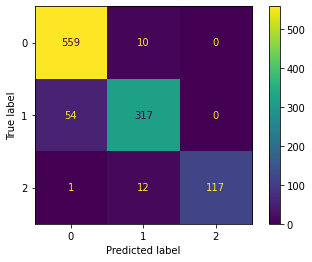

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       569
           1       0.94      0.85      0.89       371
           2       1.00      0.90      0.95       130

    accuracy                           0.93      1070
   macro avg       0.95      0.91      0.93      1070
weighted avg       0.93      0.93      0.93      1070


Métricas de avaliação de teste:
[[139   4   0]
 [ 17  75   1]
 [  0   5  27]]


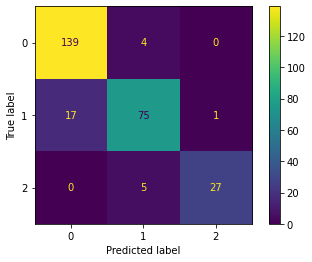

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       143
           1       0.89      0.81      0.85        93
           2       0.96      0.84      0.90        32

    accuracy                           0.90       268
   macro avg       0.92      0.87      0.89       268
weighted avg       0.90      0.90      0.90       268



In [26]:
# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_dt.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

In [27]:
df

,age,bmi,children,flag_sex,is_smoker,target
0,19,27.900,0,1,1,1
1,18,33.770,1,0,0,0
2,28,33.000,3,0,0,0
3,33,22.705,0,0,0,1
4,32,28.880,0,0,0,0
...,...,...,...,...,...,...
1333,50,30.970,3,0,0,1
1334,18,31.920,0,1,0,0
1335,18,36.850,0,1,0,0
1336,21,25.800,0,1,0,0


In [30]:
lista_etapas = [("rf", RandomForestClassifier())]

pipe_rf = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## ====================

metrica = make_scorer(f1_score, pos_label="f1")

## ====================

param_grid = {
              "rf__criterion" : ["gini", "entropy"],
              "rf__n_estimators" : range(100, 600, 100),
              "rf__max_depth" : range(5, 10),
              "rf__max_features" : range(1, 4)
}

grid_rf = GridSearchCV(estimator=pipe_rf, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10,
                        n_jobs=-1)

grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': range(5, 10),
                         'rf__max_features': range(1, 4),
                         'rf__n_estimators': range(100, 600, 100)},
             scoring=make_scorer(f1_score, pos_label=f1), verbose=10)

In [32]:
grid_rf.best_estimator_

Pipeline(steps=[('rf', RandomForestClassifier(max_depth=5, max_features=1))])


Métricas de avaliação de treino:
[[565   4   0]
 [ 64 307   0]
 [  2  11 117]]


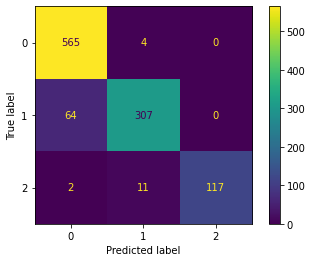

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       569
           1       0.95      0.83      0.89       371
           2       1.00      0.90      0.95       130

    accuracy                           0.92      1070
   macro avg       0.95      0.91      0.93      1070
weighted avg       0.93      0.92      0.92      1070


Métricas de avaliação de teste:
[[140   3   0]
 [ 17  76   0]
 [  0   5  27]]


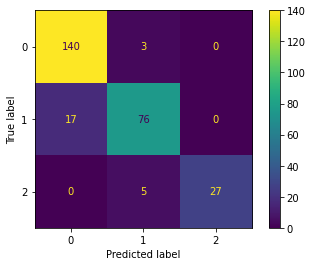

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       143
           1       0.90      0.82      0.86        93
           2       1.00      0.84      0.92        32

    accuracy                           0.91       268
   macro avg       0.93      0.88      0.90       268
weighted avg       0.91      0.91      0.91       268



In [33]:
# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_rf.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

In [34]:
lista_etapas = [("ab", AdaBoostClassifier())]

pipe_ab = Pipeline(lista_etapas)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## ====================

metrica = make_scorer(f1_score, pos_label="f1")

## ====================

param_grid = {"ab__n_estimators" : range(40, 60)}

grid_ab = GridSearchCV(estimator=pipe_ab, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_ab.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START ab__n_estimators=40.......................................
[CV 1/10; 1/20] END ..........ab__n_estimators=40;, score=nan total time=   0.0s
[CV 2/10; 1/20] START ab__n_estimators=40.......................................
[CV 2/10; 1/20] END ..........ab__n_estimators=40;, score=nan total time=   0.0s
[CV 3/10; 1/20] START ab__n_estimators=40.......................................
[CV 3/10; 1/20] END ..........ab__n_estimators=40;, score=nan total time=   0.0s
[CV 4/10; 1/20] START ab__n_estimators=40.......................................
[CV 4/10; 1/20] END ..........ab__n_estimators=40;, score=nan total time=   0.0s
[CV 5/10; 1/20] START ab__n_estimators=40.......................................
[CV 5/10; 1/20] END ..........ab__n_estimators=40;, score=nan total time=   0.0s
[CV 6/10; 1/20] START ab__n_estimators=40.......................................
[CV 6/10; 1/20] END ..........ab__n_estimators

[CV 2/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 3/10; 6/20] START ab__n_estimators=45.......................................
[CV 3/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 4/10; 6/20] START ab__n_estimators=45.......................................
[CV 4/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 5/10; 6/20] START ab__n_estimators=45.......................................
[CV 5/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 6/10; 6/20] START ab__n_estimators=45.......................................
[CV 6/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 7/10; 6/20] START ab__n_estimators=45.......................................
[CV 7/10; 6/20] END ..........ab__n_estimators=45;, score=nan total time=   0.0s
[CV 8/10; 6/20] START ab__n_estimators=45.......................................
[CV 8/10; 6/20] END ........

[CV 5/10; 11/20] END .........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 6/10; 11/20] START ab__n_estimators=50......................................
[CV 6/10; 11/20] END .........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 7/10; 11/20] START ab__n_estimators=50......................................
[CV 7/10; 11/20] END .........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 8/10; 11/20] START ab__n_estimators=50......................................
[CV 8/10; 11/20] END .........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 9/10; 11/20] START ab__n_estimators=50......................................
[CV 9/10; 11/20] END .........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 10/10; 11/20] START ab__n_estimators=50.....................................
[CV 10/10; 11/20] END ........ab__n_estimators=50;, score=nan total time=   0.0s
[CV 1/10; 12/20] START ab__n_estimators=51......................................
[CV 1/10; 12/20] END .......

[CV 6/10; 16/20] END .........ab__n_estimators=55;, score=nan total time=   0.0s
[CV 7/10; 16/20] START ab__n_estimators=55......................................
[CV 7/10; 16/20] END .........ab__n_estimators=55;, score=nan total time=   0.0s
[CV 8/10; 16/20] START ab__n_estimators=55......................................
[CV 8/10; 16/20] END .........ab__n_estimators=55;, score=nan total time=   0.0s
[CV 9/10; 16/20] START ab__n_estimators=55......................................
[CV 9/10; 16/20] END .........ab__n_estimators=55;, score=nan total time=   0.0s
[CV 10/10; 16/20] START ab__n_estimators=55.....................................
[CV 10/10; 16/20] END ........ab__n_estimators=55;, score=nan total time=   0.0s
[CV 1/10; 17/20] START ab__n_estimators=56......................................
[CV 1/10; 17/20] END .........ab__n_estimators=56;, score=nan total time=   0.0s
[CV 2/10; 17/20] START ab__n_estimators=56......................................
[CV 2/10; 17/20] END .......

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ab', AdaBoostClassifier())]),
             param_grid={'ab__n_estimators': range(40, 60)},
             scoring=make_scorer(f1_score, pos_label=f1), verbose=10)

In [35]:
grid_ab.best_estimator_

Pipeline(steps=[('ab', AdaBoostClassifier(n_estimators=40))])


Métricas de avaliação de treino:
[[522  47   0]
 [ 56 259  56]
 [  1  50  79]]


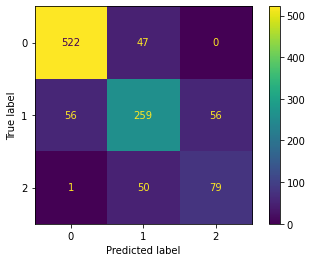

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       569
           1       0.73      0.70      0.71       371
           2       0.59      0.61      0.60       130

    accuracy                           0.80      1070
   macro avg       0.74      0.74      0.74      1070
weighted avg       0.80      0.80      0.80      1070


Métricas de avaliação de teste:
[[129  14   0]
 [ 14  66  13]
 [  0  16  16]]


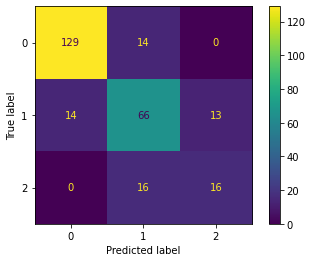

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       143
           1       0.69      0.71      0.70        93
           2       0.55      0.50      0.52        32

    accuracy                           0.79       268
   macro avg       0.71      0.70      0.71       268
weighted avg       0.79      0.79      0.79       268



In [36]:
# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = grid_ab.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = grid_ab.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

_____

# 1) GridSearch (revisão)

Conforme já vimos, o GridSearch é um método proporcionado pelo módulo *scikit-learn* para seleção de hiperparâmetros, representando a **busca exaustiva de hiperparâmetros** de um estimador.

Ele faz isso por meio do treinamento de **diversos modelos com diferentes combinações de hiperparâmetros**, e vai salvando os resultados de desempenho - medidos por um *scoring*. Ao final do processo, a melhor combinação (aquela com o melhor valor da métrica) de hiperparâmetros é selecionada. O *scikit-learn* ainda apresenta a possibilidade de fazer essa avaliação usando validação cruzada - GriSearchCV, o que aumenta a robustez estatística e a confiabilidade dos resultados obtidos.

Para encontrar mais informações sobre os *scorings* utilizados, você pode usar o [LINK](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Para utilizar quaisquer umas das técnicas, devemos informar a grade.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

O argumento mais comum de ser passado ao GridSearchCV é o **Pipeline**, onde podemos agrupar várias operações sequenciais sobre os dados. Mais informações podem ser checadas [nesse link](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

________

# 2) Random Search

O GridSearch é um excelente método para buscar hiperparâmetros de um estimador, mas tem dois principais pontos fracos:

- E se a combinação "ótima" de hiperparâmetros não estiver dentro da grade especificada? Nesse caso, o GridSearch vai chegar numa solução boa, mas não podemos garantir de fato que ela seja a melhor, visto que ele nunca vai estar olhando para a região correta.
- Para resolver a questão anterior, e se nós aumentássemos a grade informada para "cobrir uma área maior"? Nesse caso teríamos um problema de *explosão combinatória*. Vejamos um caso de dois hiperparâmetros de caráter contínuo:
    - Se cada um deles assumir 5 valores, temos 25 experimentos (que pode ser multiplicado por 5 ou 10, dependendo do cross validation que usarmos).
    - Se cada um deles assumir 10 valores, esse valor sobe para 100 experimentos
    - Se cada um deles assumir 20 valores, temos 400 experimentos
    - Para 40 valores, 1600.
    - 80 valores, 6400
    - ...
Para uma variável contínua, ela pode assumir infinitos valores, então para garantir matematicamente que vamos encontrar a solução ótima, temos de explorar infinitas possibilidades, algo que não possuímos tempo ou recursos computacionais para conseguir.
- Um terceiro ponto que precisamos ter em mente é mais voltado para o ponto de vista do negócio. Mesmo que algumas combinações sejam exploradas no GridSearch, pode ser que elas nem seja de interesse do negócio. Ainda assim, o método "gasta recursos computacionais" para explorar essas soluções.

É nesse contexto que entra o método de **Random Search** ou Busca Aleatória.

Ao invés de realizar uma busca bruta, onde todas as combinações são exploradas, o RandomSearch realiza uma amostragem aleatória de valores dos hiperparâmetros informados e somente depois realiza as combinações para o experimentador avaliar segundo o scoring.

<img src="https://miro.medium.com/max/1400/1*9W1MrRkHi0YFmBoHi9Y2Ow.png" width=500>

In [37]:
import warnings
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [39]:
# realizando a leitura dos dados
data = pd.read_csv('breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,...,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,...,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,...,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,...,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,...,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [40]:
# checando tipos de dados para retirar possíveis dados categóricos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [41]:
# eliminando a coluna 'ID'
data.drop(['id'], axis = 1, inplace = True)

In [42]:
# separando entre preditores e targets
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipe = Pipeline(steps)

In [44]:
# construindo o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# definindo a métrica
score = make_scorer(f1_score, pos_label = 'M')

In [45]:
# construindo um dicionário de DISTRIBUIÇÕES
param_dists = {
    'model__C': [0, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dists, scoring=score, cv=cvs, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__C=0.1, model__l1_ratio=0, model__penalty=l2........
[CV 1/10; 1/10] END model__C=0.1, model__l1_ratio=0, model__penalty=l2;, score=0.970 total time=   0.0s
[CV 2/10; 1/10] START model__C=0.1, model__l1_ratio=0, model__penalty=l2........
[CV 2/10; 1/10] END model__C=0.1, model__l1_ratio=0, model__penalty=l2;, score=0.903 total time=   0.0s
[CV 3/10; 1/10] START model__C=0.1, model__l1_ratio=0, model__penalty=l2........
[CV 3/10; 1/10] END model__C=0.1, model__l1_ratio=0, model__penalty=l2;, score=0.914 total time=   0.0s
[CV 4/10; 1/10] START model__C=0.1, model__l1_ratio=0, model__penalty=l2........
[CV 4/10; 1/10] END model__C=0.1, model__l1_ratio=0, model__penalty=l2;, score=1.000 total time=   0.0s
[CV 5/10; 1/10] START model__C=0.1, model__l1_ratio=0, model__penalty=l2........
[CV 5/10; 1/10] END model__C=0.1, model__l1_ratio=0, model__penalty=l2;, score=0.970 total time=   0.0s
[CV 6/10; 1/

[CV 1/10; 6/10] END model__C=1, model__l1_ratio=0, model__penalty=elasticnet;, score=nan total time=   0.0s
[CV 2/10; 6/10] START model__C=1, model__l1_ratio=0, model__penalty=elasticnet..
[CV 2/10; 6/10] END model__C=1, model__l1_ratio=0, model__penalty=elasticnet;, score=nan total time=   0.0s
[CV 3/10; 6/10] START model__C=1, model__l1_ratio=0, model__penalty=elasticnet..
[CV 3/10; 6/10] END model__C=1, model__l1_ratio=0, model__penalty=elasticnet;, score=nan total time=   0.0s
[CV 4/10; 6/10] START model__C=1, model__l1_ratio=0, model__penalty=elasticnet..
[CV 4/10; 6/10] END model__C=1, model__l1_ratio=0, model__penalty=elasticnet;, score=nan total time=   0.0s
[CV 5/10; 6/10] START model__C=1, model__l1_ratio=0, model__penalty=elasticnet..
[CV 5/10; 6/10] END model__C=1, model__l1_ratio=0, model__penalty=elasticnet;, score=nan total time=   0.0s
[CV 6/10; 6/10] START model__C=1, model__l1_ratio=0, model__penalty=elasticnet..
[CV 6/10; 6/10] END model__C=1, model__l1_ratio=0, mode

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', LogisticRegression())]),
                   param_distributions={'model__C': [0, 0.1, 1, 10],
                                        'model__l1_ratio': [0, 0.25, 0.5, 0.75,
                                                            1],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'none']},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [46]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__penalty': 'l2', 'model__l1_ratio': 0.25, 'model__C': 1}
Melhor Métrica:
0.9671587725999491


In [47]:
# analisando o melhor modelo
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none'))]
pipe = Pipeline(steps)
best_model = pipe.fit(x_train, y_train)

# realizando predições
yhat = pipe.predict(x_test)

In [48]:
# analisando-se o relatório de classificação
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           B       0.93      0.97      0.95        72
           M       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



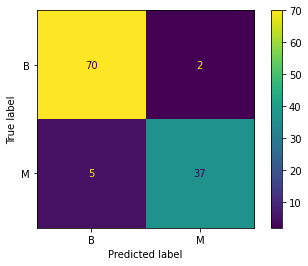

In [49]:
# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

_____

## Exercício 1

Para praticarmos e para comparar também, repita o mesmo procedimento com uma árvore de Decisão e com uma Floresta Aleatória. Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros para cada modelo - utilizando a estrutura do Pipeline conforme mostramos
- compare os resultados obtidos entre si e também com os resultados da regressão logística

_____

A classe `RandomizedSearchCV` apresenta vários atributos interessantes que podem ser manipulados, com maior detalhe no [LINK](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Dentre os principais podemos citar algumas:
- `param_distributions`: podemos aqui especificar uma distribuição estatística para gerar valores aleatórios ao invés de uma lista simples. Isso nos permite explorar situações e maiores espaços de busca de forma mais simples
- `n_iter`: aqui podemos controlar quantas amostras aleatórias serão realizadas. Temos de pensar no *trade-off* entre confiabilidade estatística vs custo computacional
- `n_jobs`: relativo à paralelização dos cálculos. Ajuda do aumento da velocidade da execução do algoritmo
- `refit`: se colocamos True, então ele vai ajustar um modelo final com os melhores parâmetros o que acelera nosso trabalho.

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy.stats import norm

In [50]:
data = pd.read_csv('WineQT.csv')

In [59]:
low_corr = data.corr()['quality'].abs() <=0.15

In [60]:
data_filtered = data.drop(columns=data.columns[low_corr], axis=1)

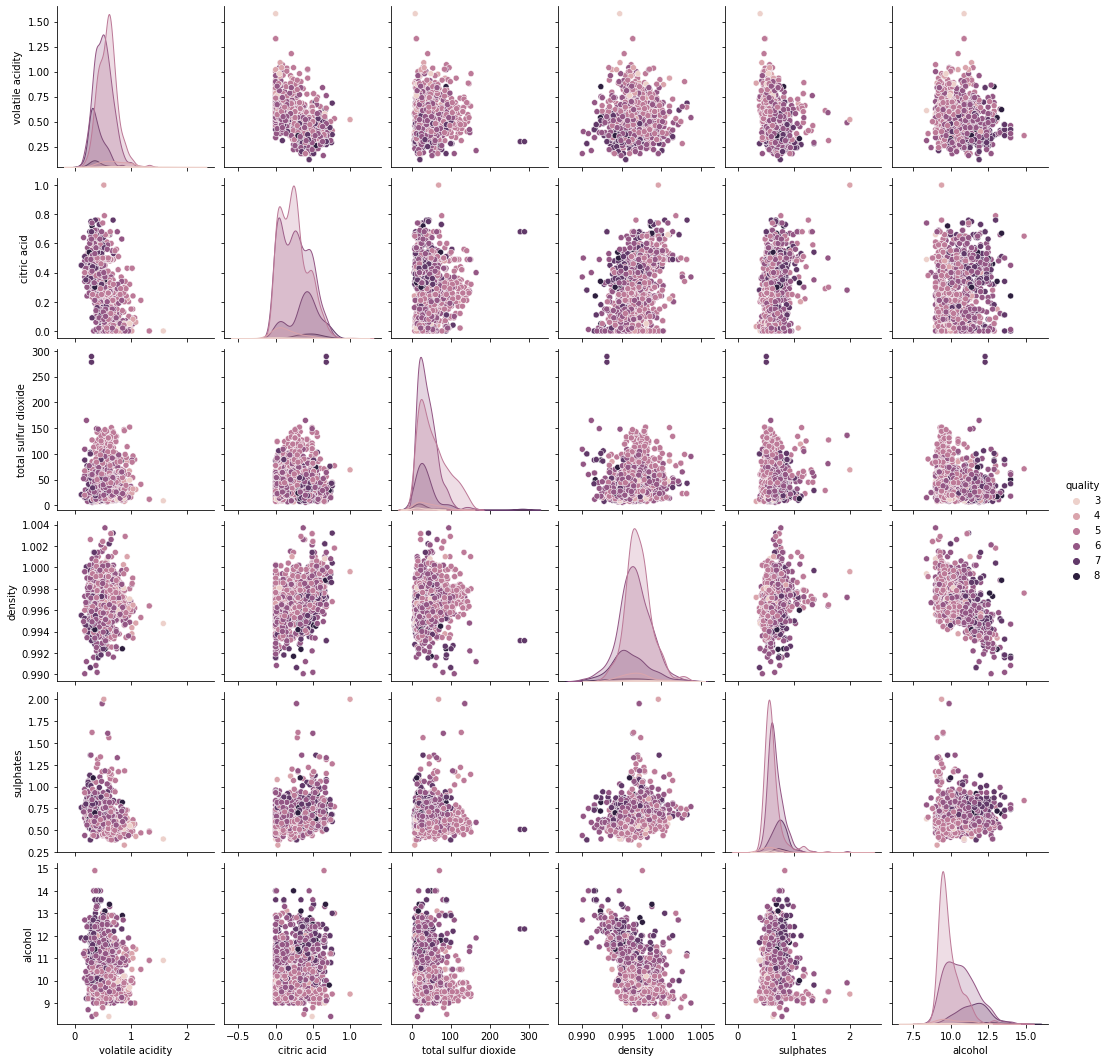

In [62]:
sns.pairplot(data_filtered, hue='quality')

In [63]:
x = data.drop(['quality'], axis = 1)
y = data[['quality']]

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestClassifier())]

pipe_rf = Pipeline(steps)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## ====================

metrica = make_scorer(f1_score, pos_label="f1")

In [70]:
param_distr = {"rf__criterion" : ["gini", "entropy"],
              "rf__n_estimators" : range(100, 1000, 100),
              "rf__max_depth" : range(5, 10),
              "rf__max_features" : range(1, 4)}

rs_rf = RandomizedSearchCV(estimator=pipe_rf, 
                             param_distributions=param_distr,
                             n_iter=15,
                             scoring=metrica,
                             cv=splitter,
                             verbose=10,
                             random_state=42,
                             n_jobs=-1)

rs_rf.fit(x_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'rf__criterion': ['gini', 'entropy'],
                                        'rf__max_depth': range(5, 10),
                                        'rf__max_features': range(1, 4),
                                        'rf__n_estimators': range(100, 1000, 100)},
                   random_state=42, scoring=make_scorer(f1_score, pos_label=f1),
                   verbose=10)

In [72]:
rs_rf.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=6, max_features=1,
                                        n_estimators=400))])


Métricas de avaliação de treino:
[[  0   0   5   0   0   0]
 [  0   2  17   7   0   0]
 [  0   0 336  50   0   0]
 [  0   0  58 312   0   0]
 [  0   0   0  59  55   0]
 [  0   0   0  12   1   0]]


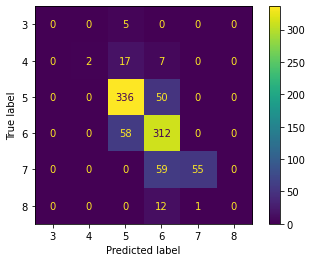

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       1.00      0.08      0.14        26
           5       0.81      0.87      0.84       386
           6       0.71      0.84      0.77       370
           7       0.98      0.48      0.65       114
           8       0.00      0.00      0.00        13

    accuracy                           0.77       914
   macro avg       0.58      0.38      0.40       914
weighted avg       0.78      0.77      0.75       914


Métricas de avaliação de teste:
[[ 0  0  1  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0 77 20  0  0]
 [ 0  0 25 66  1  0]
 [ 0  0  4 22  3  0]
 [ 0  0  0  3  0  0]]


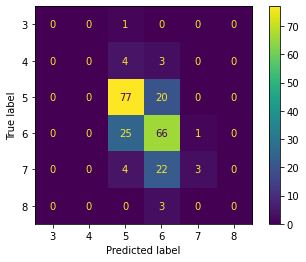

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.69      0.79      0.74        97
           6       0.58      0.72      0.64        92
           7       0.75      0.10      0.18        29
           8       0.00      0.00      0.00         3

    accuracy                           0.64       229
   macro avg       0.34      0.27      0.26       229
weighted avg       0.62      0.64      0.59       229



In [71]:
# ============================================

print("\nMétricas de avaliação de treino:")

y_pred_train = rs_rf.predict(x_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = rs_rf.predict(x_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

In [73]:
data['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

_____

## Exercício 2

Para praticarmos e para comparar também, repita o mesmo procedimento com um KNN. Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros - utilizando a estrutura do Pipeline conforme mostramos
     - use uma distribuição uniforme para o valor de *k* entre 1 e 100
- compare os resultados obtidos entre si e também com os resultados da regressão linear

_____

## Exercício 3

Para praticarmos e para comparar também, repita o mesmo procedimento com uma floresta aleatória Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros  - utilizando a estrutura do Pipeline conforme mostramos
   - use distribuições uniformes para o número de árvores e para a profundidade máxima
- aplique uma busca em Grade com muitos parâmetros para tentar encontrar o mesmo resultado.
- compare os resultados obtidos entre si